# Unscented Kalman Filter (UKF)
metode UKF dalam proses estimasinya diawali dengan unscented transformation sebelum diimplementasikan ke dalam algoritma UKF itu sendiri.

## Unscented Transformation
Unscented Transformation (UT) merupakan sebuah metode untuk menghitung mean dan kovariansi dari sebuah variabel acak yang mengalami transformasi nonlinier. Misalkan diberikan sebuah model sistem stokastik nonlinier dan model pengukuran dengan noise yg bersifat aditif:
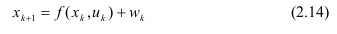


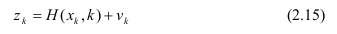

### Non-augmented Unscented Transformation
Non-augmented Unscented Transformation merupakan unscented transformation dari variabel keadaan xk berdimensi- N x yang didekati dengan 2 Nx + 1 titik sigma xi berdasar persamaan dibawah ini:

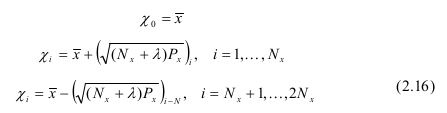

### Augmented Unscented Transformation
Augmented Unscented Transformation adalah unscented transformation yang menggunakan variabel keadaan yang diperbesar. Dari persamaan (2.14) dan (2.15), diperoleh sistem yang diperbesar seperti berikut.
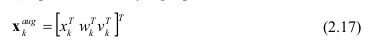
                            dengan dimensi N = Nx+Nw+Nv dan kovariansi sebagai berikut.


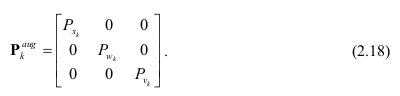

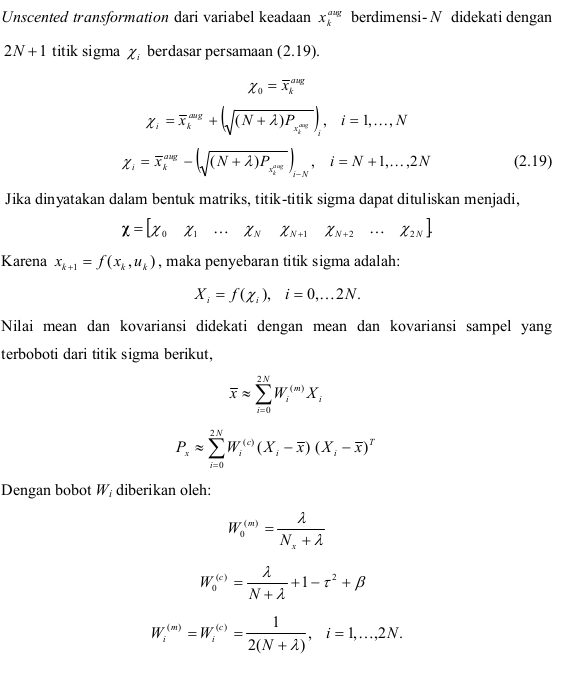

### Algoritma Unscented Kalman Filter
Unscented Kalman Filter merupakan perluasan dari unscented transformation.Pada tahap inisialisasi didefinisikan sistem yang diperbesar dari persamaan (2.14) dan (2.15) seperti pada persamaan (2.17) beserta matriks kovariansi yang dituliskan pada persamaan (2.18). Kemudian dilanjutkan dengan pembentukan matriks titik sigma berdasar persamaan (2.19). Titik-titik sigma yang terbentuk itulah yang akan diestimasi pada tahap prediksi dan koreksi.


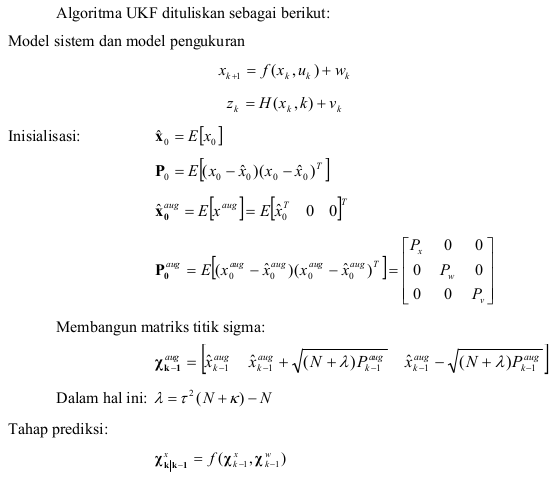

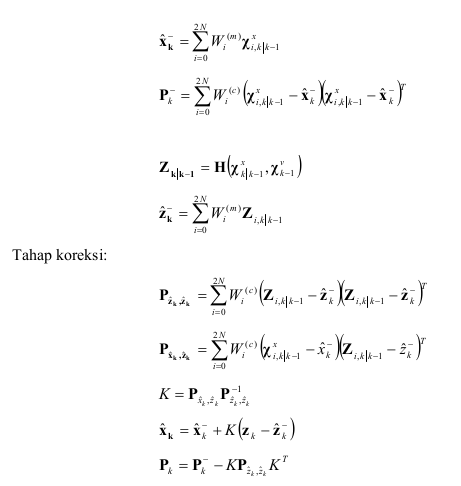

In [1]:
import cv2
import math
import numpy
import pykalman

In [2]:
class System:
    
    def __init__(self):
        # true target and sensor positions
        self.target = numpy.float32((256, 256))
        self.sensors = numpy.float32([(128, 128), (256, 384), (384, 128)])

        cv2.namedWindow('UKF')
        cv2.setMouseCallback('UKF', self.mouse_callback)

    # generates an observation vector
    # [|p - s0|, |p - s1|, ..., |p - sn|] + noise
    def measurement(self):
        dists = numpy.linalg.norm(self.sensors - self.target, axis=1)
        return dists + numpy.abs(numpy.random.normal(0.0, 25.0, dists.size))

    # updates the target position
    def mouse_callback(self, event, x, y, flags, userdata):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.pushed = True
        elif event == cv2.EVENT_LBUTTONUP:
            self.pushed = False

        if hasattr(self, 'pushed') and self.pushed:
            self.target = numpy.float32((x, y))

    # draw
    def draw(self, filter, measurement):
        canvas = numpy.ones((512, 512, 3), dtype=numpy.uint8) * 255

    # draw sensors and observations
        for r, sensor in zip(measurement, self.sensors):
            cv2.circle(canvas, tuple(sensor.astype(numpy.int32)), 5, (0, 255, 0), 2)
            cv2.circle(canvas, tuple(sensor.astype(numpy.int32)), int(r), (128, 128, 128), 1)

    # draw true target position
        cv2.circle(canvas, tuple(self.target.astype(numpy.int32)), 2, (255, 0, 0), 2)
        print("+++++++++++++++++++++++++++++++++++++")
        print("target",self.target)

# draw estimated target position and error ellipse
        cv2.circle(canvas, tuple(filter.mean.astype(numpy.int32)), 5, (0, 0, 255), 2)
        eigenvalues, eigenvectors = numpy.linalg.eig(filter.cov)
        idx = [x[0] for x in sorted(enumerate(eigenvalues), key=lambda x: x[1])]
        angle = math.degrees(math.atan2(eigenvectors[0, idx[1]], eigenvectors[1, idx[1]]))
        axes = (int(eigenvalues[idx[1]]), int(eigenvalues[idx[0]]))
        cv2.ellipse(canvas, tuple(filter.mean.astype(numpy.int32)), axes, angle, 0, 360, (0, 0, 255))
        print("angle", angle)
        print("axes", axes)

        print("+++++++++++++++++++++++++++++++++++++")
        cv2.imshow('UKF', canvas)


In [3]:
class Filter:
    def __init__(self, sensors):
        self.sensors = sensors

        # initialize ukf
        trans_cov = numpy.eye(2) * 20                 # transition noise covariance matrix
        obs_cov = numpy.eye(sensors.shape[0]) * 100   # observation noise covariance matrix
        self.mean = numpy.random.normal(256, 256, 2)  # initial mean
        self.cov = numpy.eye(2) * 128                 # initial covariance
        # In this system, we assume simple additive noises. So, AdditiveUnscentedKalmanFilter is more suitable (fast and robust).
        # But, you can use the usual UKF which doesn't assume such additive noises as well.
        # self.ukf = pykalman.UnscentedKalmanFilter(self.transition, self.observation, trans_cov, obs_cov, self.mean, self.cov)
        self.ukf = pykalman.AdditiveUnscentedKalmanFilter(self.transition_, self.observation_, trans_cov, obs_cov, self.mean, self.cov)
        print("transition noise covariance matrix", trans_cov)
        print("observation noise covariance matrix", obs_cov)
        print("initial mean", self.mean)
        print("initial covariance", self.cov)

    # transition function for Additive UKF
    # constant position
    def transition_(self, state):
        return state

    # observation function for Additive UKF
    # expected range data
    def observation_(self, state):
        expected = numpy.linalg.norm(self.sensors - state, axis=-1)
        return expected

    # transition function for usual UKF
    def transition(self, state, noise):
        return state + noise

    # observation function for usual UKF
    def observation(self, state, noise):
        expected = numpy.linalg.norm(self.sensors - state, axis=-1)
        return expected + noise

    # update state using ukf
    def update(self, measurement):
        self.mean, self.cov = self.ukf.filter_update(self.mean, self.cov, measurement)
        print("=================================================")
        print("mean", self.mean)
        print("cov", self.cov)
        print("=================================================")


In [4]:
# entry point
def main():
    system = System()
    filter = Filter(system.sensors)

    while cv2.waitKey(50) != 0x1b:
        obs = system.measurement()
        filter.update(obs)
        system.draw(filter, obs)
        print("measurement", obs)

In [5]:
if __name__ == '__main__':
    main()

transition noise covariance matrix [[20.  0.]
 [ 0. 20.]]
observation noise covariance matrix [[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]]
initial mean [349.76665753 440.79525269]
initial covariance [[128.   0.]
 [  0. 128.]]
mean [348.83602974 348.3662361 ]
cov [[ 66.78658467 -20.55548905]
 [-20.55548905  44.9823816 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 121.02983677744429
axes (79, 32)
+++++++++++++++++++++++++++++++++++++
measurement [191.68426445 139.63290717 215.74121985]
mean [342.48341356 306.90098356]
cov [[38.60280147 -4.81966147]
 [-4.81966147 31.25851677]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 116.34795317883741
axes (40, 28)
+++++++++++++++++++++++++++++++++++++
measurement [182.10333573 157.87427572 197.51812219]
mean [336.21730473 282.74504821]
cov [[34.33029041  0.55079688]
 [ 0.55079688 26.57473037]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 85.95791434298116
axes (34, 26)
+++++++++++++++

mean [269.22973301 269.03086095]
cov [[37.41082529  0.33025582]
 [ 0.33025582 22.7138526 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.71337174766842
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [232.94115498 146.72503133 205.04582674]
mean [253.45446422 270.75956332]
cov [[37.756009    0.9866368 ]
 [ 0.9866368  22.61611899]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 86.2870769689035
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [191.84554325 150.94138432 246.13922792]
mean [253.23754774 263.74148587]
cov [[38.14861252  0.17199318]
 [ 0.17199318 22.45526861]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.37216022029399
axes (38, 22)
+++++++++++++++++++++++++++++++++++++
measurement [184.73213778 136.68078786 188.12414518]
mean [256.95295909 262.99096286]
cov [[37.60997351 -0.12377682]
 [-0.12377682 22.66918416]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.474622881

mean [262.06335705 266.61528451]
cov [[36.21517611  0.49408091]
 [ 0.49408091 23.04188398]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.8550667269743
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [216.09324297 128.18916944 199.26171416]
mean [261.57500271 266.3494058 ]
cov [[37.06637789  0.57092497]
 [ 0.57092497 22.74161332]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.72124897656143
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [200.89402515 133.2873001  196.27526132]
mean [255.49537202 264.98269233]
cov [[37.41109442  0.56737813]
 [ 0.56737813 22.66532751]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.7997463494773
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [190.7596934  140.65630522 209.15690103]
mean [258.73687414 262.83564188]
cov [[37.42766725  0.16360857]
 [ 0.16360857 22.6793902 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.3644991289

measurement [210.39573797 140.99362244 185.61997688]
mean [257.557173   255.35409921]
cov [[36.68125281  0.67428872]
 [ 0.67428872 22.94786522]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.19585329652556
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [181.19984912 157.74756002 201.80330853]
mean [258.56024145 255.65853474]
cov [[36.14363977  0.33301739]
 [ 0.33301739 23.14496573]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.5334027693861
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [192.14569617 139.61740872 186.32838518]
mean [269.33455754 262.99845204]
cov [[35.9549947   0.28017676]
 [ 0.28017676 23.1907926 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.74315330793682
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [229.77438599 134.20964843 184.80383675]
mean [262.15657936 261.1403194 ]
cov [[36.55324027  0.95240642]
 [ 0.95240642 22.96638812]]
++++++++++++++++++++++

mean [257.18496764 263.26891563]
cov [[35.15743282  0.10220219]
 [ 0.10220219 23.42582775]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.50090702245491
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [225.47708909 148.93161407 218.42768963]
mean [251.84483278 258.65805915]
cov [[36.29158189  0.11249759]
 [ 0.11249759 22.96002215]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.51655880481395
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [186.43513207 155.91785545 206.75181077]
mean [255.80011271 264.19694996]
cov [[36.31334886 -0.22991284]
 [-0.22991284 23.01524942]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.99020080080723
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [225.48977849 153.33293859 212.98005929]
mean [252.76905705 258.9742825 ]
cov [[36.88144623 -0.09310745]
 [-0.09310745 22.8085169 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.37905062

+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.84010763256993
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [187.28981288 171.12083988 198.50793604]
mean [250.06389393 261.76556031]
cov [[36.76015485 -0.57302392]
 [-0.57302392 22.995299  ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.37970543481708
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [200.00249034 135.24185973 205.71008808]
mean [258.37032339 263.10989699]
cov [[36.82180166 -0.58609251]
 [-0.58609251 22.91181841]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.40844826891029
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [208.67755555 131.81503957 182.87271556]
mean [254.84100358 255.86348017]
cov [[36.98368932 -0.0476556 ]
 [-0.0476556  22.82057508]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.19278414059293
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [186.22606854 161.683

mean [253.95353133 259.38683107]
cov [[36.4380258  -0.10776313]
 [-0.10776313 23.0283693 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.46040262377551
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [194.03566809 138.89355913 197.14513349]
mean [260.47433794 262.15133901]
cov [[36.45256137 -0.17032781]
 [-0.17032781 23.00235847]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.72541499852848
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [208.06248073 131.26327255 184.80082105]
mean [264.28935696 263.48912653]
cov [[36.72874828  0.23277706]
 [ 0.23277706 22.889295  ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.0366587956182
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [210.98281255 138.73518885 191.23860967]
mean [256.52730767 261.88650684]
cov [[36.96649368  0.62152178]
 [ 0.62152178 22.82519159]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.488259574

mean [251.94509106 260.94915725]
cov [[36.49572673 -0.58678471]
 [-0.58678471 22.9733928 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.48006423755534
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [188.58495457 134.76200585 195.98808653]
mean [252.24422415 261.90335899]
cov [[36.63270118 -0.46737969]
 [-0.46737969 22.93028579]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.9512952832907
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [189.62863669 129.0547467  193.49075854]
mean [246.11017924 263.60742572]
cov [[36.78622317 -0.40738346]
 [-0.40738346 22.87935644]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.67648843776144
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [198.49770953 153.50746093 225.53381785]
mean [257.03242299 266.86566515]
cov [[36.99526977 -0.78520512]
 [-0.78520512 22.82987521]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 93.163058718

mean [252.7815195  260.58709711]
cov [[36.5904986   0.35267133]
 [ 0.35267133 22.96123243]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.51873402173615
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [185.50618751 144.57357841 211.42893211]
mean [254.92881384 258.79210908]
cov [[36.63228109 -0.08762506]
 [-0.08762506 22.93527784]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.36652340912097
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [192.60863133 139.93667886 187.89291434]
mean [264.64171575 266.31837937]
cov [[36.47399998 -0.0999554 ]
 [-0.0999554  22.99863494]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.42496826331403
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [239.11500531 146.01097276 201.78776705]
mean [269.63710887 254.70029017]
cov [[37.12664017  0.53166554]
 [ 0.53166554 22.74952752]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.88505309

measurement [191.99726265 138.89407628 185.70984525]
mean [258.46684254 257.66819085]
cov [[36.50886159  0.03999178]
 [ 0.03999178 22.99263572]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.83047533995706
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [187.34959417 133.79354359 184.05641418]
mean [255.44530637 258.48061918]
cov [[36.30775912  0.17384006]
 [ 0.17384006 23.06240775]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.24818794809418
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [200.48510276 155.78865997 210.16976027]
mean [255.86419643 254.55732999]
cov [[3.63073201e+01 2.40995695e-02]
 [2.40995695e-02 2.30472250e+01]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.89586820246852
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [209.23919578 179.40143313 207.90143565]
mean [253.91675474 256.38778281]
cov [[ 3.59105527e+01 -4.77768958e-04]
 [-4.77768958e-04  2.32064802

angle 87.28753586263073
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [204.68979791 175.35768213 211.71150427]
mean [260.44725615 247.10247213]
cov [[36.97205547  0.51840533]
 [ 0.51840533 22.88281879]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.8956280100875
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [189.28890966 184.72025631 184.35331286]
mean [257.04442676 255.00652153]
cov [[35.40816405  0.465041  ]
 [ 0.465041   23.49548141]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.76784582771762
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [190.35603956 129.52953277 197.89619529]
mean [241.25362    261.74151879]
cov [[35.5866474   0.22754305]
 [ 0.22754305 23.31740877]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.9378898850095
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [181.03045045 144.38768632 242.83758938]
mean [252.32588037 264.01048214]
cov [[

mean [268.33594364 255.2628083 ]
cov [[35.08904662  0.45283311]
 [ 0.45283311 23.49694439]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.76633883849581
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [218.76818468 151.76747729 187.89386471]
mean [263.16684959 251.08888707]
cov [[35.46097811  0.93704374]
 [ 0.93704374 23.35415337]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 85.60034203723852
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [186.59498147 161.46761707 194.37396701]
mean [253.91517478 255.43420944]
cov [[35.21986781  0.78036696]
 [ 0.78036696 23.46673806]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 86.21788706249392
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [184.8022267  144.39362537 213.61072129]
mean [261.68230406 256.84445009]
cov [[35.54476416  0.13583015]
 [ 0.13583015 23.288387  ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.36512884

mean [263.20326062 261.83096002]
cov [[36.93334521 -0.50333577]
 [-0.50333577 22.80093969]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.03718946143044
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [212.4176389  148.17872224 181.802655  ]
mean [261.68330202 250.99725273]
cov [[36.88234592  0.29496779]
 [ 0.29496779 22.85076272]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.79625400116812
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [186.07825664 170.98129522 185.6879409 ]
mean [258.0611057  255.60633159]
cov [[35.77518084  0.46827291]
 [ 0.46827291 23.31314396]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.85109596814912
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [192.24636914 138.85292449 199.60479917]
mean [255.65372228 248.76802677]
cov [[35.7982804   0.29438293]
 [ 0.29438293 23.24082821]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.65780445

mean [251.58634119 244.26350172]
cov [[34.67471851 -0.5798456 ]
 [-0.5798456  23.70665906]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 93.01782869617047
axes (34, 23)
+++++++++++++++++++++++++++++++++++++
measurement [203.58930899 186.77751559 201.2096091 ]
mean [249.29354219 257.34876331]
cov [[34.22458269 -0.48097943]
 [-0.48097943 23.87649223]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.65547725121152
axes (34, 23)
+++++++++++++++++++++++++++++++++++++
measurement [206.7948716  139.45036825 220.09819719]
mean [258.65702981 262.01011866]
cov [[35.31509676 -0.59357898]
 [-0.59357898 23.3426817 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.83140531530087
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [219.82849042 138.69631438 188.91525238]
mean [254.65449069 260.9229296 ]
cov [[ 3.62306533e+01 -3.46520458e-02]
 [-3.46520458e-02  2.29851080e+01]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
a

angle 90.80028086128847
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [240.45828486 142.0232701  216.26487564]
mean [255.23093577 267.36130084]
cov [[37.06334731  0.08640731]
 [ 0.08640731 22.71416887]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.65499522466423
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [203.3426602  147.44516238 213.61443192]
mean [255.20139531 256.67691896]
cov [[ 3.75197531e+01 -2.10112058e-02]
 [-2.10112058e-02  2.26061714e+01]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.0807217373963
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [182.72972355 155.0603098  183.59646447]
mean [266.80909471 266.64515194]
cov [[36.62133874 -0.05933453]
 [-0.05933453 22.98956392]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.24938296438013
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [239.71357578 135.13121102 195.44078395]
mean [272.23856174 267

+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.08005698902676
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [226.71895343 159.16374214 215.85485959]
mean [256.190801   271.47288025]
cov [[36.87661041 -0.29880485]
 [-0.29880485 22.83348222]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.21838476068768
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [233.11070314 148.27343129 225.49119187]
mean [257.96275835 259.80752857]
cov [[37.84535233 -0.09178299]
 [-0.09178299 22.49243979]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.34251007802906
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [203.14715028 175.52038178 196.20575354]
mean [255.00310119 259.28244676]
cov [[37.07840526  0.09718396]
 [ 0.09718396 22.83098663]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.60920039935084
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [200.53309486 157.728

+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.80501834629402
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [213.35748253 137.88888046 196.70630037]
mean [255.25788611 259.35934044]
cov [[36.38368024  0.26699978]
 [ 0.26699978 22.9922793 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.85823300668518
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [190.24580698 148.77051404 204.71394254]
mean [245.12584629 266.26720136]
cov [[36.42702439  0.04419357]
 [ 0.04419357 22.99140403]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.81154062733233
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [196.35216332 142.12120101 237.0052227 ]
mean [246.93810458 264.422875  ]
cov [[37.08322155 -0.69361856]
 [-0.69361856 22.76511011]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.76696826568136
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [187.79787884 129.799

mean [259.84341631 256.14542096]
cov [[35.98810892  0.54324129]
 [ 0.54324129 23.19565812]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.57271566299988
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [191.2836633  144.82901438 198.94172109]
mean [266.43429461 250.9522672 ]
cov [[35.93976916  0.4353683 ]
 [ 0.4353683  23.1884461 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.04678292571188
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [211.68712457 172.85622227 182.25457899]
mean [265.19417069 257.49945102]
cov [[35.39122387  0.81544012]
 [ 0.81544012 23.43664434]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 86.11574589329273
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [199.85885556 130.74076817 191.72456582]
mean [268.29236501 264.52321196]
cov [[35.8184496   0.87009831]
 [ 0.87009831 23.22725381]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 86.06557372

measurement [215.74203662 145.62770648 210.43016555]
mean [246.55543539 270.23010395]
cov [[38.19041341 -0.80340627]
 [-0.80340627 22.4898138 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.92167720209675
axes (38, 22)
+++++++++++++++++++++++++++++++++++++
measurement [194.34351514 131.37608071 212.53080876]
mean [253.08942397 266.98042429]
cov [[38.2601706  -0.91457489]
 [-0.91457489 22.48347652]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 93.30667264470105
axes (38, 22)
+++++++++++++++++++++++++++++++++++++
measurement [218.79363104 155.41129389 199.77511946]
mean [254.10914865 268.31253783]
cov [[37.99293263 -0.51258952]
 [-0.51258952 22.56005965]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.90023793342067
axes (38, 22)
+++++++++++++++++++++++++++++++++++++
measurement [211.28363941 142.84695007 209.66475543]
mean [253.36349969 251.80628935]
cov [[38.01632892 -0.30546842]
 [-0.30546842 22.53057425]]
+++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 96.25623148826276
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [228.2971956  128.54426478 183.98019161]
mean [253.75366916 266.2129388 ]
cov [[37.28448858 -0.49064232]
 [-0.49064232 22.72153864]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.92744630300088
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [191.72834628 130.85976926 202.40058884]
mean [255.36208731 271.57353255]
cov [[37.49902547 -0.3198206 ]
 [-0.3198206  22.65304171]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.23353525525884
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [216.35930532 131.9429144  211.91073992]
mean [256.35623173 254.71549318]
cov [[38.13057891 -0.15512834]
 [-0.15512834 22.43954923]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.56637719510681
axes (38, 22)
+++++++++++++++++++++++++++++++++++++
measurement [184.86602216 174.187

mean [254.06606631 261.44825947]
cov [[37.64658059  0.27440628]
 [ 0.27440628 22.61725639]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.95435492458421
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [184.62848388 150.19960624 205.39271993]
mean [245.79971387 259.90895458]
cov [[ 3.71648371e+01 -3.24309970e-02]
 [-3.24309970e-02  2.28019319e+01]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.12937122360118
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [188.99422997 159.44245675 222.69832275]
mean [243.51894383 258.85468537]
cov [[36.77903113 -0.67215897]
 [-0.67215897 22.94708702]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.77555319638316
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [187.29703441 148.02310819 206.73789071]
mean [240.57139392 251.88916275]
cov [[36.51338652 -1.03396529]
 [-1.03396529 23.05437001]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
a

mean [244.71546702 265.94681918]
cov [[36.0235675   0.12800066]
 [ 0.12800066 23.16344502]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.42979323294539
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [189.4986881  130.70241647 238.05368677]
mean [249.52548335 270.57815161]
cov [[36.87210406 -0.68790776]
 [-0.68790776 22.82683314]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.79730225087286
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [213.2146301  129.28990342 205.26537559]
mean [254.66034162 264.63761371]
cov [[37.73940607 -0.67400231]
 [-0.67400231 22.54339319]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.53465624838687
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [197.15713452 138.46453806 184.05135727]
mean [259.09726129 252.73199925]
cov [[37.53296323 -0.32267947]
 [-0.32267947 22.65954144]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.24225498

mean [267.42029292 261.34231237]
cov [[36.30408082  1.50703517]
 [ 1.50703517 23.15178007]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 83.54629271779764
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [202.04221605 158.01189169 220.75228697]
mean [272.62351912 256.45051725]
cov [[36.57421624  1.25853607]
 [ 1.25853607 23.01603905]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 84.74139515245952
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [213.85131873 164.44087231 183.08284296]
mean [274.62611934 257.73730476]
cov [[36.18394452  1.48662402]
 [ 1.48662402 23.21573544]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 83.54342703725621
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [212.15094746 149.061802   187.24690349]
mean [268.42956875 255.57823347]
cov [[36.13911775  1.68442774]
 [ 1.68442774 23.24868758]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 82.67679963

angle 88.64442431019641
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [204.91604541 158.07068465 181.8756116 ]
mean [257.17603017 248.4061973 ]
cov [[35.79568922  0.48507213]
 [ 0.48507213 23.24932129]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.78920941551776
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [187.01737654 174.39618144 200.14048678]
mean [260.15784464 250.69562925]
cov [[35.07988212  0.24185992]
 [ 0.24185992 23.53860787]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.80000713371139
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [209.02576754 162.80258875 196.27911032]
mean [266.55373545 260.66970183]
cov [[35.02337533  0.34910491]
 [ 0.34910491 23.52435532]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.26265970255477
axes (35, 23)
+++++++++++++++++++++++++++++++++++++
measurement [220.47782442 129.85982585 190.44334658]
mean [255.05840968 266.26525036]
cov 

measurement [237.32099391 132.08249797 186.23282864]
mean [257.83320451 263.57912155]
cov [[38.59197904  0.21678207]
 [ 0.21678207 22.33979557]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.23593328021808
axes (38, 22)
+++++++++++++++++++++++++++++++++++++
measurement [183.62536062 155.04980103 202.77390528]
mean [254.35997425 255.49895298]
cov [[37.78161863  0.19695609]
 [ 0.19695609 22.64194556]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.2547918781521
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [183.42323207 160.16146567 194.96133393]
mean [254.51957823 257.49231601]
cov [[36.60294012 -0.03966832]
 [-0.03966832 23.04891149]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.16768457865322
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [193.34630095 138.72861062 194.69117972]
mean [244.45846782 253.38226587]
cov [[36.32964036 -0.10989897]
 [-0.10989897 23.0846676 ]]
++++++++++++++++++++++

mean [266.89515274 263.71865027]
cov [[37.78247545  1.34255761]
 [ 1.34255761 22.65587601]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 84.96715127608711
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [197.79691554 145.95215237 194.67464077]
mean [265.68920194 262.74083572]
cov [[37.43235222  1.17869411]
 [ 1.17869411 22.77921581]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 85.43029997212871
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [200.96682401 141.06860978 194.18591141]
mean [256.37178907 257.55552703]
cov [[37.19247994  1.04148179]
 [ 1.04148179 22.83971444]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 85.87126307374875
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [181.35850591 157.4181431  208.47151846]
mean [255.26075275 256.22763061]
cov [[36.57482143  0.38282169]
 [ 0.38282169 23.01960332]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.38359030

mean [256.40560829 258.40695938]
cov [[37.29859266  0.37369829]
 [ 0.37369829 22.7087699 ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 88.53372894536784
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [184.29160118 145.3630041  185.49754168]
mean [263.31324758 254.25423094]
cov [[36.70976885  0.15535453]
 [ 0.15535453 22.94854014]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.35328107395353
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [214.70490984 169.97898882 187.3960227 ]
mean [261.08000448 253.96080403]
cov [[36.0355922   0.52522163]
 [ 0.52522163 23.20626147]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.65958143623715
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [186.71213109 140.58364867 186.2058737 ]
mean [258.09247254 254.81805206]
cov [[35.73888896  0.50784557]
 [ 0.50784557 23.28792524]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.66820291

mean [250.71414731 264.68074555]
cov [[37.13822905 -0.80733613]
 [-0.80733613 22.78940235]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 93.2102396555516
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [202.62233386 134.00628191 189.7803588 ]
mean [253.52335155 253.77996992]
cov [[37.27708854 -0.6287971 ]
 [-0.6287971  22.74031576]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.4722091577644
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [186.93858479 163.0775734  181.62266771]
mean [252.34081445 254.5362216 ]
cov [[36.22257964 -0.3766892 ]
 [-0.3766892  23.15277385]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.64951529024577
axes (36, 23)
+++++++++++++++++++++++++++++++++++++
measurement [181.49107428 135.34378928 189.31243992]
mean [248.84075024 253.14166807]
cov [[35.87346614 -0.36589494]
 [-0.36589494 23.24311146]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.6579759561

mean [245.83228094 266.91845516]
cov [[36.61872435 -0.45629295]
 [-0.45629295 22.99233407]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.91574418621518
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [198.73506266 129.3435868  226.81626379]
mean [246.81444059 264.70439062]
cov [[37.24455927 -0.82584325]
 [-0.82584325 22.74260278]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 93.24882459722492
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [189.53670873 133.86529784 197.28369511]
mean [245.47428396 264.28656189]
cov [[37.30816554 -0.88922379]
 [-0.88922379 22.74935577]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 93.48226228029351
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [187.72715989 133.59561319 203.4431991 ]
mean [245.52907687 265.5762556 ]
cov [[37.2861526  -0.99685801]
 [-0.99685801 22.77750634]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 93.91216849

mean [250.22849785 263.39169801]
cov [[36.62059778 -0.22333363]
 [-0.22333363 22.93964206]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 90.93498810807627
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [198.7935924  137.63387201 209.56092288]
mean [248.37445388 267.93730941]
cov [[36.92274413 -0.45504089]
 [-0.45504089 22.83064524]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 91.84754356187227
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [205.17593545 137.36890124 217.7320423 ]
mean [250.33041451 270.95277246]
cov [[37.49439406 -0.66361415]
 [-0.66361415 22.64306692]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.55341149758085
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [213.57051049 137.35312566 212.22647386]
mean [254.06512968 251.49978164]
cov [[38.05407958 -0.61418362]
 [-0.61418362 22.47479995]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 92.25411435

mean [269.34470964 266.33172504]
cov [[37.32181933  0.75912556]
 [ 0.75912556 22.71033575]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.03389727503199
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [220.89720458 148.13168986 195.95447749]
mean [260.60455944 268.31084258]
cov [[37.466033    1.1349469 ]
 [ 1.1349469  22.71640529]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 85.62555219392803
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [195.47442954 135.99274704 217.23283117]
mean [262.16425739 258.00532366]
cov [[37.78358945  0.70324402]
 [ 0.70324402 22.58451509]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.35651738120174
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [193.91190847 159.2611008  182.79393283]
mean [258.54357991 254.25916975]
cov [[36.86341758  0.64455803]
 [ 0.64455803 22.94432276]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.35432477

mean [265.44112375 270.93017369]
cov [[36.9649278   0.11531836]
 [ 0.11531836 22.817546  ]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 89.53301113046598
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [228.5392975  139.3652949  212.08751657]
mean [264.71487899 259.28290276]
cov [[37.78342265  0.67015391]
 [ 0.67015391 22.54367005]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 87.48693760704518
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [190.97191065 159.77000815 185.30286291]
mean [266.25897194 264.51751523]
cov [[36.987514    0.79889165]
 [ 0.79889165 22.89468724]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 86.76583725291074
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [209.51867635 128.17615766 193.63846927]
mean [259.76167697 264.46251728]
cov [[37.17333778  0.94776574]
 [ 0.94776574 22.80710697]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 86.24180436

mean [233.62279954 269.60056982]
cov [[36.75557052 -1.23893394]
 [-1.23893394 22.99002441]]
+++++++++++++++++++++++++++++++++++++
target [256. 256.]
angle 95.10212712845733
axes (36, 22)
+++++++++++++++++++++++++++++++++++++
measurement [187.24988041 131.60634947 245.2819315 ]
mean [223.11881209 275.01784731]
cov [[37.39706867 -1.85195743]
 [-1.85195743 22.81521119]]
+++++++++++++++++++++++++++++++++++++
target [211. 291.]
angle 97.12609781700755
axes (37, 22)
+++++++++++++++++++++++++++++++++++++
measurement [202.30041599 150.12418095 255.99963154]
mean [198.80351892 304.80675193]
cov [[37.82610943 -2.63984184]
 [-2.63984184 22.8453588 ]]
+++++++++++++++++++++++++++++++++++++
target [152. 341.]
angle 99.70702350218932
axes (38, 22)
+++++++++++++++++++++++++++++++++++++
measurement [238.64618669 123.50730836 336.39584593]
mean [161.4194181  323.14088907]
cov [[37.15236727 -3.62691263]
 [-3.62691263 23.43580391]]
+++++++++++++++++++++++++++++++++++++
target [130. 353.]
angle 103.9357697

mean [227.59870362  64.44430555]
cov [[30.48358369 -1.36366332]
 [-1.36366332 26.60714402]]
+++++++++++++++++++++++++++++++++++++
target [237. 137.]
angle 107.5644356787319
axes (30, 26)
+++++++++++++++++++++++++++++++++++++
measurement [158.86429255 279.88958863 147.36193423]
mean [226.36180187  80.06767796]
cov [[28.12266555 -0.33762501]
 [-0.33762501 28.03402618]]
+++++++++++++++++++++++++++++++++++++
target [235. 159.]
angle 131.2608005576507
axes (28, 27)
+++++++++++++++++++++++++++++++++++++
measurement [143.9335215  237.94287355 204.17951478]
mean [229.7698614  103.44955467]
cov [[2.62554430e+01 2.09210771e-02]
 [2.09210771e-02 2.98814934e+01]]
+++++++++++++++++++++++++++++++++++++
target [231. 169.]
angle -179.6694375181236
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [116.3974987  223.54349974 166.05584261]
mean [229.8606863  126.57264644]
cov [[24.45087552 -0.15972645]
 [-0.15972645 32.52352084]]
+++++++++++++++++++++++++++++++++++++
target [222. 186.]
angl

angle 81.18117773331647
axes (63, 19)
+++++++++++++++++++++++++++++++++++++
measurement [272.65709885 121.28652117 196.53311159]
mean [261.47876813 394.30102916]
cov [[64.29638787  4.33139172]
 [ 4.33139172 19.90141243]]
+++++++++++++++++++++++++++++++++++++
target [321. 268.]
angle 84.47931282811811
axes (64, 19)
+++++++++++++++++++++++++++++++++++++
measurement [243.79209857 134.95081775 170.06586889]
mean [293.27866961 376.86158179]
cov [[61.13540643 -1.02841328]
 [-1.02841328 21.5419702 ]]
+++++++++++++++++++++++++++++++++++++
target [305. 242.]
angle 91.48688334248466
axes (61, 21)
+++++++++++++++++++++++++++++++++++++
measurement [222.89942282 154.4143972  175.98905789]
mean [347.63774518 319.79356269]
cov [[38.32484527  0.0554072 ]
 [ 0.0554072  24.902988  ]]
+++++++++++++++++++++++++++++++++++++
target [286. 215.]
angle 89.76348083540275
axes (38, 24)
+++++++++++++++++++++++++++++++++++++
measurement [186.77290716 208.58790296 152.43727739]
mean [338.43411428 273.06623225]
cov 

mean [325.14497322 362.70024804]
cov [[33.76589047  3.19770369]
 [ 3.19770369 25.03485094]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 71.88878066504807
axes (34, 23)
+++++++++++++++++++++++++++++++++++++
measurement [316.04327004  88.94288126 281.13759967]
mean [331.97786975 362.89120707]
cov [[30.8443739  1.2299979]
 [ 1.2299979 26.0855827]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 76.33193970491571
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [313.17507972  91.5447479  242.21048586]
mean [334.38050894 361.76489691]
cov [[29.68271484  0.18307143]
 [ 0.18307143 26.56931027]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 86.64635250908071
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [311.92414019  86.41442027 237.67494763]
mean [334.0068582  361.80481297]
cov [[29.27559345 -0.20121881]
 [-0.20121881 26.75092253]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 94.528433377036

mean [340.97125971 362.57811078]
cov [[28.73435573 -2.6660024 ]
 [-2.6660024  27.70356716]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.5292475587106
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [298.58707481  74.87280989 240.17143896]
mean [341.53146593 363.13000855]
cov [[28.82148953 -1.57323001]
 [-1.57323001 27.28792107]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 122.00781682559814
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [310.4948151   96.15823392 247.63410587]
mean [339.0342233  379.11885117]
cov [[28.83329229 -1.27498347]
 [-1.27498347 27.17276537]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 118.4640036547564
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [325.56124973  86.30891504 292.16680897]
mean [337.90830414 376.63334177]
cov [[28.89002719 -2.4860627 ]
 [-2.4860627  27.39462138]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.630463

mean [338.20057604 371.10088803]
cov [[28.87775924 -2.63401856]
 [-2.63401856 27.49475795]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.64512793296603
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [316.89663826  83.90506751 239.66615267]
mean [344.60410852 370.83014673]
cov [[28.84082531 -2.16210787]
 [-2.16210787 27.39143402]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.73493526144064
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [322.08419111 106.36146498 251.33643603]
mean [345.4400722 366.697519 ]
cov [[28.78430958 -2.26396288]
 [-2.26396288 27.45491896]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.81892939691751
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [306.2633761  104.79331148 247.72036586]
mean [345.57162505 364.70782748]
cov [[28.75471956 -1.98942389]
 [-1.98942389 27.40257818]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.615287

mean [339.79958885 367.73063496]
cov [[28.77840671 -1.46826853]
 [-1.46826853 27.23305768]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 121.12223313904751
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [320.80041351  73.54018604 246.78378808]
mean [346.13161237 385.2921254 ]
cov [[28.78448418 -1.53706521]
 [-1.53706521 27.23575808]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 121.63067192661359
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [349.47795666 100.49839457 291.28294511]
mean [339.12169649 381.54113917]
cov [[29.07888502 -3.39991855]
 [-3.39991855 27.57566065]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.7671218994378
axes (31, 24)
+++++++++++++++++++++++++++++++++++++
measurement [318.08471529  76.50582316 258.23686677]
mean [335.19269583 375.32988389]
cov [[29.13401805 -3.46915511]
 [-3.46915511 27.64083184]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.92733

+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 115.8057082887813
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [332.73052166  89.31507359 243.3614638 ]
mean [339.44796035 368.79608551]
cov [[28.81217365 -1.72895939]
 [-1.72895939 27.23981344]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 122.77404781388294
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [319.41626931  85.66715468 240.04954501]
mean [337.85014105 375.50417949]
cov [[28.79741821 -1.70232072]
 [-1.70232072 27.26079983]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 122.85444680705322
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [327.8513534   79.35260573 263.12730915]
mean [334.68262495 375.03677618]
cov [[28.82954994 -2.23945439]
 [-2.23945439 27.37392046]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.99801101804564
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [322.12739099  72.

mean [345.34056037 379.86549091]
cov [[29.27598919 -4.43617081]
 [-4.43617081 28.0212249 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 130.97518511094572
axes (33, 24)
+++++++++++++++++++++++++++++++++++++
measurement [305.49507987  86.38805026 260.68446928]
mean [348.72983227 373.99347425]
cov [[29.18050675 -3.90045984]
 [-3.90045984 27.90751186]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 130.36593353251476
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [313.31555994 110.7881716  250.74533318]
mean [343.31881227 368.77115314]
cov [[28.97149519 -3.31882695]
 [-3.31882695 27.81222436]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 130.0465874705883
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [308.43658165  86.33985876 242.96739239]
mean [340.59335262 366.93380914]
cov [[28.84768505 -2.42581138]
 [-2.42581138 27.54505867]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.48546

mean [338.91111314 376.45991771]
cov [[29.06355987 -3.33153773]
 [-3.33153773 27.59153985]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.77110138334587
axes (31, 24)
+++++++++++++++++++++++++++++++++++++
measurement [309.01675868  91.35813693 251.04992911]
mean [335.82090854 373.57515426]
cov [[28.98029563 -2.93908857]
 [-2.93908857 27.5617365 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.21621608342173
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [313.78645572  79.03429392 249.73091701]
mean [341.04834257 373.15747391]
cov [[28.90628933 -2.39414564]
 [-2.39414564 27.43409178]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.45477278491872
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [325.11458667  96.80604657 249.90765228]
mean [342.35487725 370.12703972]
cov [[28.84729592 -2.39519966]
 [-2.39519966 27.45932784]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.9208

mean [352.25448773 381.06592653]
cov [[29.00469723 -3.06550433]
 [-3.06550433 27.53720392]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.2695821133352
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [357.22031219 108.80301349 241.41995342]
mean [343.78284184 376.25840102]
cov [[29.07009266 -3.77452676]
 [-3.77452676 27.83432051]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 130.35159947951252
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [325.74532264  71.1832527  241.99609267]
mean [341.08785152 373.69130161]
cov [[28.98454258 -3.27219905]
 [-3.27219905 27.73469044]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.59391195951196
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [329.05018686  75.93993273 239.83179392]
mean [338.91194412 372.02831349]
cov [[28.89997384 -2.74902143]
 [-2.74902143 27.59053572]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.30187

mean [336.00046434 367.65805797]
cov [[28.79834801 -1.47595226]
 [-1.47595226 27.21035729]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 120.86088213371494
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [314.75489872  77.27541026 246.40958122]
mean [336.29832973 385.43466651]
cov [[28.82946877 -1.35060563]
 [-1.35060563 27.16055311]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 119.14528987171339
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [349.54201858  72.70248969 284.88693844]
mean [337.55884572 373.77738041]
cov [[29.10860123 -3.04463803]
 [-3.04463803 27.39721891]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.15102894504412
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [305.23449739  92.67158371 238.9391444 ]
mean [341.62025452 365.6877075 ]
cov [[28.94911605 -2.52510989]
 [-2.52510989 27.41462012]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.5493

angle 126.47502993253238
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [340.92957282  86.82045837 237.67990885]
mean [346.24148852 373.03638939]
cov [[28.71921002 -2.34515957]
 [-2.34515957 27.52600498]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.86343535330768
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [328.16010864  87.4434029  253.85246664]
mean [348.8004811  368.88052519]
cov [[28.76047143 -2.58857327]
 [-2.58857327 27.57658614]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.55967263280402
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [308.16058616 112.77412121 251.25182939]
mean [348.86948804 367.75787144]
cov [[28.73245982 -2.43449022]
 [-2.43449022 27.5646814 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.25645558983737
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [318.73028221 100.14270069 246.39948672]
mean [355.47067732 372.24266922]


+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 130.77556258580856
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [301.313959   121.86610712 239.35144125]
mean [347.76023534 364.07907542]
cov [[28.67880616 -2.34249576]
 [-2.34249576 27.6187366 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.6252081622239
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [322.58754702  82.08207141 237.44607266]
mean [344.15588784 372.91988013]
cov [[28.7100193  -1.91807514]
 [-1.91807514 27.44114472]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.84872658630465
axes (30, 26)
+++++++++++++++++++++++++++++++++++++
measurement [317.54889504  92.43468165 274.19504178]
mean [345.63055137 374.05542272]
cov [[28.75162232 -2.34234018]
 [-2.34234018 27.49715534]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.50450383967848
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [306.4129992  111.

measurement [332.5925946  100.7414641  251.23945273]
mean [345.82796501 381.82056094]
cov [[28.8064296  -3.04768583]
 [-3.04768583 27.73563715]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 130.01817125345917
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [338.91488266  78.32990191 267.48327117]
mean [338.72158677 371.71625562]
cov [[29.03299741 -3.60867977]
 [-3.60867977 27.79370566]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 130.12838301152203
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [308.29822984  74.61489956 235.89652957]
mean [346.3377184  364.84738219]
cov [[28.90770373 -2.57634242]
 [-2.57634242 27.52775302]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.5036677550879
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [312.92689589 112.56608378 236.32271762]
mean [341.83785266 364.53776101]
cov [[28.8010879  -1.99019336]
 [-1.99019336 27.40380254]]
+++++++++++++++++++

mean [339.75727641 387.1906896 ]
cov [[28.88891597 -2.5613013 ]
 [-2.5613013  27.48826208]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.35380666086627
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [325.04445062  98.77508822 300.21293906]
mean [333.93063398 379.32123307]
cov [[29.27800505 -3.75440534]
 [-3.75440534 27.62615194]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.7966009063088
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [309.53275946  74.05169639 251.03187734]
mean [341.96712526 383.25767549]
cov [[29.13863362 -3.17653344]
 [-3.17653344 27.55495319]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.00134600513604
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [347.28379089  94.09185094 257.76141875]
mean [335.3714763  378.54078037]
cov [[29.21276737 -3.65976187]
 [-3.65976187 27.68932605]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.12133

mean [334.3542735  378.44558809]
cov [[28.91023122 -2.23945755]
 [-2.23945755 27.3286159 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.27530895713889
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [326.31474024  85.31168054 257.91343183]
mean [332.62678174 369.53340156]
cov [[28.9457278  -2.57622669]
 [-2.57622669 27.40706766]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.68648525394154
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [299.79777618  82.92421078 241.1861303 ]
mean [336.02740026 375.77122846]
cov [[28.90260386 -1.73408631]
 [-1.73408631 27.2253777 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 122.09567493219323
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [339.87429361  77.70506913 253.09508147]
mean [333.77964258 375.20879758]
cov [[28.87650713 -2.20187515]
 [-2.20187515 27.34047284]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.3855

angle 127.70392521686144
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [307.96732872  74.75093279 241.21090603]
mean [336.5309336  363.28087724]
cov [[28.94767526 -1.90081185]
 [-1.90081185 27.28027346]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 123.15881095230596
axes (30, 26)
+++++++++++++++++++++++++++++++++++++
measurement [300.92711184  99.93591294 239.37264366]
mean [332.33280187 362.91157113]
cov [[28.94583373 -1.14433561]
 [-1.14433561 27.07719846]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 115.38466750713434
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [301.2095958   78.86214777 247.07647115]
mean [331.52292726 363.88212505]
cov [[29.02587387 -0.63749232]
 [-0.63749232 26.917006  ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 105.57821203943693
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [301.99765975  85.91073744 253.26648828]
mean [332.59802722 362.36581221]


mean [338.39406169 370.00482009]
cov [[29.00314322 -3.12388626]
 [-3.12388626 27.69409512]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.0832168883115
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [305.11079411  82.7952643  250.04885874]
mean [333.17503761 373.05206978]
cov [[28.88652144 -2.23886093]
 [-2.23886093 27.44062897]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.05215690520346
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [313.08914701  74.01196863 260.45684402]
mean [337.36691808 373.92094257]
cov [[28.86994088 -1.98591598]
 [-1.98591598 27.3282493 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 124.39298194729196
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [322.11011274  92.57736777 254.83749973]
mean [345.29668688 373.47905965]
cov [[28.84654171 -2.16680758]
 [-2.16680758 27.36896608]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.58642

angle 126.22399947594113
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [339.58217099  97.67734275 277.03887441]
mean [341.3831135  375.55347683]
cov [[29.05393898 -3.27693092]
 [-3.27693092 27.60533666]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.7681424168662
axes (31, 24)
+++++++++++++++++++++++++++++++++++++
measurement [313.93746658  90.84866553 247.10961539]
mean [345.24660377 372.55917887]
cov [[28.95414217 -2.93570249]
 [-2.93570249 27.58988689]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.45955161095932
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [332.8437587   92.30753857 237.66241971]
mean [344.50009461 372.33213015]
cov [[28.85509011 -2.70989686]
 [-2.70989686 27.58663797]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.41377447916
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [324.03222337  89.83660205 248.94934196]
mean [338.3492468  376.78637542]
cov 

angle 127.60446660060543
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [300.54130826 101.80201205 253.14029575]
mean [336.25792684 369.42323177]
cov [[28.92369559 -2.34371339]
 [-2.34371339 27.41292943]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.06788729468566
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [307.17751623  88.44945863 249.37258755]
mean [338.77640003 373.59364687]
cov [[28.86621281 -1.81892828]
 [-1.81892828 27.2861094 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 123.26113903341138
axes (30, 26)
+++++++++++++++++++++++++++++++++++++
measurement [323.15073486  91.85652455 260.97239563]
mean [336.1895649  366.99311373]
cov [[28.83234431 -2.13910161]
 [-2.13910161 27.36675531]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.54500974048337
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [306.930617    81.49250826 237.10139041]
mean [345.29952465 363.12676831]


mean [342.62767591 360.8114379 ]
cov [[28.86242771 -1.72702494]
 [-1.72702494 27.28239125]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 122.70926520343066
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [304.47210903 107.07936943 239.17433462]
mean [335.05644798 371.75799061]
cov [[28.87197779 -1.20101145]
 [-1.20101145 27.13138402]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 117.03576864661098
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [314.23058097  72.94798847 273.8916026 ]
mean [332.34273962 368.01199091]
cov [[28.83332602 -1.58984783]
 [-1.58984783 27.20764922]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 121.460395354793
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [307.22567876  77.21364733 243.44708397]
mean [332.45812005 367.04512055]
cov [[28.87728368 -1.2420778 ]
 [-1.2420778  27.10711053]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 117.263440

measurement [327.51539439  97.33192418 243.28153409]
mean [346.35568282 374.35924993]
cov [[29.06402456 -3.58781521]
 [-3.58781521 27.86292925]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 130.2488093264795
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [334.56664627  78.00047696 240.05684455]
mean [342.26456817 369.00503273]
cov [[28.93451357 -3.14289225]
 [-3.14289225 27.75066102]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.6669822036969
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [306.04114028  89.48231527 245.32285672]
mean [350.2068818  362.77087548]
cov [[28.83943085 -2.33674077]
 [-2.33674077 27.50768941]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.04736242926424
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [313.20278625 119.00842384 236.37009657]
mean [343.52177731 361.59521774]
cov [[28.74920537 -1.93455074]
 [-1.93455074 27.42345017]]
++++++++++++++++++++

angle 127.96798990899948
axes (31, 24)
+++++++++++++++++++++++++++++++++++++
measurement [310.69517444 135.19249426 242.01276443]
mean [338.61803827 383.88688662]
cov [[28.96623385 -3.03534097]
 [-3.03534097 27.66057805]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.9309887642305
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [318.52438522  74.89564345 291.7357906 ]
mean [345.58963026 373.8901284 ]
cov [[29.17370055 -3.5602048 ]
 [-3.5602048  27.67139031]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.04304857447457
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [318.04855842 107.18777708 236.43200467]
mean [346.00919191 381.10811687]
cov [[28.96452795 -3.05852243]
 [-3.05852243 27.6621319 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.99024128268204
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [343.83389504  86.70894724 263.76334615]
mean [343.84079791 376.75748032]
c

+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.56842429565768
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [302.37039808  80.80825724 238.62830571]
mean [329.22512673 370.54730573]
cov [[29.07128102 -2.68584489]
 [-2.68584489 27.44686316]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.5872495005241
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [301.03898489  75.02686438 250.6513128 ]
mean [332.2439045  367.36569001]
cov [[28.96595641 -1.70518057]
 [-1.70518057 27.20824672]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 121.36664730064217
axes (30, 26)
+++++++++++++++++++++++++++++++++++++
measurement [298.02098676  97.32267362 255.08398289]
mean [336.406418   376.79328658]
cov [[28.93491243 -1.21707656]
 [-1.21707656 27.08890013]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 116.41202929720649
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [329.58533357  90.

 [-3.22133111 27.61660819]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.96687293729337
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [301.18242614  95.44314027 289.44702945]
mean [336.81770579 379.48828571]
cov [[29.19919931 -3.57441989]
 [-3.57441989 27.63494243]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.82874238948583
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [326.22903096  79.75946094 246.76127465]
mean [345.78407873 370.83759661]
cov [[29.11223663 -3.24147028]
 [-3.24147028 27.60098295]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.4389922741809
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [317.08111797 111.79081166 236.81751958]
mean [354.20032441 368.87272521]
cov [[28.89570469 -2.68960562]
 [-2.68960562 27.57060214]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.08070848369812
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
me

measurement [311.97512154  82.2041182  240.40599396]
mean [334.69275334 370.53490424]
cov [[28.82309783 -1.29967002]
 [-1.29967002 27.15660925]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 118.66763022073476
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [319.18591834  73.94830649 256.43103515]
mean [338.1924997 378.0626245]
cov [[28.82456142 -1.49124403]
 [-1.49124403 27.18636301]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 120.61061103816323
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [334.45542319  87.25062369 265.62446511]
mean [334.09509131 380.22398855]
cov [[28.87427557 -2.42638657]
 [-2.42638657 27.38363137]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.46221003259342
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [323.86463617  72.36011767 262.61180055]
mean [331.34297114 378.9140941 ]
cov [[28.98549703 -2.81330956]
 [-2.81330956 27.45163067]]
++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.28915337541571
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [324.57606239  78.77886511 238.10384055]
mean [331.00478781 372.31898355]
cov [[28.79640615 -1.97650572]
 [-1.97650572 27.34367254]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 124.91079777742625
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [300.67583221  71.613486   265.95317448]
mean [332.11453352 371.91810595]
cov [[28.8455834  -1.72403607]
 [-1.72403607 27.24192777]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 122.52872258813977
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [309.03170379  87.24095675 257.39099269]
mean [331.02179131 366.33245293]
cov [[28.85289763 -1.64939729]
 [-1.64939729 27.21247675]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 121.77990567739094
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [308.27677797  75

mean [329.58887399 382.32741804]
cov [[29.06858131 -3.08333334]
 [-3.08333334 27.51884007]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.94658445752964
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [305.9422418   83.84509545 275.64951582]
mean [328.3508868  370.56188823]
cov [[29.1469186  -3.10805928]
 [-3.10805928 27.48140625]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.50039386773751
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [298.00969147  76.63577106 236.72678275]
mean [337.04815652 367.16781257]
cov [[28.99851438 -1.80679299]
 [-1.80679299 27.20592233]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 121.80768204546662
axes (30, 26)
+++++++++++++++++++++++++++++++++++++
measurement [322.5202199   95.77207948 235.99553434]
mean [335.97355023 372.65482449]
cov [[28.89674961 -1.47158144]
 [-1.47158144 27.16881594]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 119.7913

mean [332.45139566 373.19382062]
cov [[28.88331875 -2.19827182]
 [-2.19827182 27.34745607]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.37197484888542
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [305.4344699   84.83103433 261.36352407]
mean [334.76219789 376.29827279]
cov [[28.87212221 -1.95288184]
 [-1.95288184 27.28857373]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 123.9652264425149
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [322.05651108  87.04944137 262.12652463]
mean [343.4870805  371.70853686]
cov [[28.88321357 -2.27696885]
 [-2.27696885 27.3579231 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.741151375473
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [306.75610138 119.70429812 255.39932741]
mean [340.30514264 376.80057621]
cov [[28.81322157 -2.33041026]
 [-2.33041026 27.44437604]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.8164551

mean [335.01270893 375.02368376]
cov [[28.93096241 -2.3893659 ]
 [-2.3893659  27.35414552]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.86944491558762
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [321.66445091  79.21595121 244.12668613]
mean [338.73155123 385.60427827]
cov [[28.89669779 -2.31142137]
 [-2.31142137 27.37146835]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.8702800264399
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [328.49152884  99.54161882 290.19188974]
mean [339.42005578 377.5263653 ]
cov [[29.19009383 -3.47672531]
 [-3.47672531 27.55306998]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.37615714455555
axes (31, 24)
+++++++++++++++++++++++++++++++++++++
measurement [320.46405035  86.26436656 241.42555787]
mean [331.44059975 374.65712179]
cov [[29.05170143 -3.11348673]
 [-3.11348673 27.58031042]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.35262

target [321. 355.]
angle 129.82281316578306
axes (33, 24)
+++++++++++++++++++++++++++++++++++++
measurement [303.36664662  92.52451984 274.66810785]
mean [355.36955671 374.19854741]
cov [[29.40128719 -4.05011832]
 [-4.05011832 27.82481609]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.49337325720617
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [328.11253315 131.54813361 236.47548792]
mean [345.32005765 368.47075184]
cov [[29.04531057 -3.66540627]
 [-3.66540627 27.92932837]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 130.67211055838922
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [308.9411293   79.00512935 239.66615055]
mean [342.68779795 363.38812732]
cov [[28.86521255 -2.61182653]
 [-2.61182653 27.62087002]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.30055616210063
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [304.90350451  92.20646003 238.69555713]
mean [334.1596

+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 120.49465126427975
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [304.28512464  78.33548589 250.53602077]
mean [328.84924028 366.06682482]
cov [[28.883523   -1.15092322]
 [-1.15092322 27.08317965]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 115.98498382932527
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [299.11197188  76.99545519 251.70311916]
mean [331.22924278 364.79931492]
cov [[28.97883221 -0.73539119]
 [-0.73539119 26.94900402]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 107.96325534932437
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [314.12586429  80.74847366 239.1599314 ]
mean [340.38152683 384.421258  ]
cov [[29.00566379 -0.60420414]
 [-0.60420414 26.90912925]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 104.97922307860101
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [361.56892736  87

mean [332.43866181 387.52664665]
cov [[29.17762202 -3.56095443]
 [-3.56095443 27.69756803]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.1300325576896
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [300.72527761  92.50931883 296.23797741]
mean [336.78028003 378.66802125]
cov [[29.45954506 -3.93849505]
 [-3.93849505 27.63790237]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.48931001118027
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [317.65375425  91.26149868 243.13137434]
mean [346.45889827 375.78502809]
cov [[29.18772596 -3.28461929]
 [-3.28461929 27.59705001]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.19419189137292
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [335.88439587 105.30321608 242.56486356]
mean [357.42430918 374.17941701]
cov [[28.99750198 -3.16884365]
 [-3.16884365 27.68169812]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.13555

mean [334.06455285 372.75879396]
cov [[28.85382336 -1.07642208]
 [-1.07642208 27.09161853]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 115.34902544726363
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [317.5461648   79.14113062 269.01953833]
mean [343.52966889 371.21693845]
cov [[28.83051422 -1.59785158]
 [-1.59785158 27.19671242]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 121.46081558825081
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [329.60111997 104.39822614 242.21413246]
mean [344.50885016 370.63809483]
cov [[28.77433316 -2.05486473]
 [-2.05486473 27.36420215]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 125.53093607627865
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [303.32059774 109.52522693 264.26105449]
mean [346.22124015 366.69951644]
cov [[28.75813499 -2.20548135]
 [-2.20548135 27.43758718]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 126.6667

mean [336.68723204 382.88827769]
cov [[29.14371751 -3.4781584 ]
 [-3.4781584  27.75704306]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.36320751637192
axes (31, 24)
+++++++++++++++++++++++++++++++++++++
measurement [327.9672792   76.84241247 268.5936848 ]
mean [333.46359126 397.69482937]
cov [[29.21205556 -3.55193487]
 [-3.55193487 27.68219398]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 128.92331022263443
axes (32, 24)
+++++++++++++++++++++++++++++++++++++
measurement [336.88873722  80.44134711 307.32696904]
mean [333.01617208 380.60586655]
cov [[30.24362547 -5.03797189]
 [-5.03797189 27.60266556]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.65642313451882
axes (34, 23)
+++++++++++++++++++++++++++++++++++++
measurement [299.61720853  84.54193639 240.2072957 ]
mean [343.62552878 376.30911479]
cov [[29.54279219 -3.72500019]
 [-3.72500019 27.58333789]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.6320

mean [335.65444282 383.26317918]
cov [[28.81319049 -2.02505706]
 [-2.02505706 27.32342834]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 124.9024278461118
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [322.08945473  83.61003452 285.97278338]
mean [343.07137439 380.55857416]
cov [[29.04953668 -3.04012516]
 [-3.04012516 27.4666093 ]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 127.70379111588277
axes (31, 25)
+++++++++++++++++++++++++++++++++++++
measurement [321.28841939 109.60319774 259.12568393]
mean [355.49188951 381.66674803]
cov [[29.07468202 -3.38939568]
 [-3.38939568 27.64249245]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 129.03513441629954
axes (31, 24)
+++++++++++++++++++++++++++++++++++++
measurement [363.08805935 108.79904223 242.16891969]
mean [345.23251308 378.24070359]
cov [[29.12905712 -4.05720009]
 [-4.05720009 27.95462662]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 130.88226

target [321. 355.]
angle 123.50729323512613
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [300.90623817  80.08817972 246.8445621 ]
mean [338.25294283 370.91007321]
cov [[28.88032436 -1.05650067]
 [-1.05650067 27.09108529]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 114.87143536120499
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [340.49792467  73.25397393 247.65438569]
mean [335.32054876 374.17181769]
cov [[28.81144708 -1.60657342]
 [-1.60657342 27.22325203]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 121.8488610092952
axes (29, 26)
+++++++++++++++++++++++++++++++++++++
measurement [304.85637211  89.55680594 272.52980072]
mean [342.93237957 372.93094936]
cov [[28.82754296 -1.97148285]
 [-1.97148285 27.29816047]]
+++++++++++++++++++++++++++++++++++++
target [321. 355.]
angle 124.39995653806271
axes (30, 25)
+++++++++++++++++++++++++++++++++++++
measurement [331.27580347  99.11220027 243.37204477]
mean [344.62787